In [1]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
model_yolov9 = YOLO('model-weights/yolov9s.pt')

In [4]:
class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        
        # Frontend feature extraction (based on VGG16)
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat = [512, 512, 512, 256, 128, 64]
        
        self.frontend = make_layers(self.frontend_feat) 
        self.backend = make_layers(self.backend_feat, in_channels=512, dilation=True)
        
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        
        if not load_weights:
            # Load pre-trained VGG16 weights and initialize layers
            mod = models.vgg16(pretrained=True)
            self._initialize_weights()
            
            # Transfer the pre-trained VGG16 weights to the frontend
            frontend_state_dict = self.frontend.state_dict()
            mod_state_dict = mod.state_dict()
            
            for i, (key, value) in enumerate(frontend_state_dict.items()):
                frontend_state_dict[key].copy_(mod_state_dict[list(mod_state_dict.keys())[i]])

    def forward(self, x):
        # Forward pass through frontend, backend, and output layer
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

    def _initialize_weights(self):
        # Custom weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# Helper function to make layers from configuration
def make_layers(cfg, in_channels=3, batch_norm=False, dilation=False):
    layers = []
    d_rate = 2 if dilation else 1 
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate, dilation=d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

csrnet_model = CSRNet(load_weights=False)
weights_path = "model-weights/CrowdCountingWeights.pth" 
checkpoint = torch.load(weights_path, map_location=device)
csrnet_model.load_state_dict(checkpoint)
csrnet_model.eval()
csrnet_model.to(device)

# Image transformation 
csrnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((768, 1024)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/Users/dhruv590/Projects/Laurreto.io/Laurreto-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dhruv590/Projects/Laurreto.io/Laurreto-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Function to apply YOLOv9-based people detection (for moderate-density crowds)
def count_people_with_yolov9(frame):
    results = model_yolov9(frame) 
    people_count = 0
    
    # Iterate through detections
    for detection in results:
        for box in detection.boxes:
            if box.cls[0] == 0:
                people_count += 1
                bbox = box.xyxy[0].cpu().numpy().astype(int)
                cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    return people_count, frame

In [6]:
def count_heads(frame):
    # Initialize HOG detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
    # Resize the frame for speed
    resized_frame = cv2.resize(frame, (640, 480))

    # Detect people using HOG + SVM
    (rects, _) = hog.detectMultiScale(resized_frame, winStride=(4, 4), padding=(8, 8), scale=1.05)

    head_count = 0
    for (x, y, w, h) in rects:
        cv2.rectangle(resized_frame, (x, y), (x + w, y + int(h / 4)), (255, 0, 0), 2)
        head_count += 1

    return head_count, resized_frame

In [7]:
def calculate_density(frame):
    height, width, _ = frame.shape
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_white_pixels = cv2.countNonZero(gray_frame)
    density = num_white_pixels / (height * width)
    return max(0, min(density, 1))

In [8]:
def estimate_density_map(frame, model):
    input_tensor = csrnet_transform(frame).unsqueeze(0).to(device)
    with torch.no_grad():
        density_map = model(input_tensor)
    
    density_map = density_map.squeeze(0).cpu().numpy()
    total_people = np.sum(density_map)
    scaling_factor = 50
    scaled_crowd_count = total_people * scaling_factor
    cv2.putText(frame, f'Crowd size: {int(scaled_crowd_count)}', (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return scaled_crowd_count

In [9]:
# Apply the hybrid approach
def estimate_crowd_size(frame):
    density = calculate_density(frame)
    
    if density < 0.3:
        head_count, frame_with_heads = count_heads(frame)
        print(f"Low-density crowd, heads detected: {head_count}")
        return head_count, frame_with_heads
    elif density < 0.7:
        people_count, frame_with_people = count_people_with_yolov9(frame)
        print(f"Moderate-density crowd, people detected: {people_count}")
        return people_count, frame_with_people
    else:
        crowd_size = estimate_density_map(frame, csrnet_model)
        print(f"High-density crowd, estimated crowd size: {crowd_size}")
        return crowd_size, frame

In [10]:
def process_video(video_path, start_time=14, end_time=32):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return 

    fps = cap.get(cv2.CAP_PROP_FPS)
    start_frame = int(start_time * fps)
    end_frame = int(end_time * fps)

    frame_count = 0
    total_people_counts = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1

        if start_frame <= frame_count <= end_frame:
            crowd_size, frame_with_detections = estimate_crowd_size(frame)
            total_people_counts.append(crowd_size)

            if frame_count % 100 == 0:
                plt.imshow(cv2.cvtColor(frame_with_detections, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
        
        if frame_count > end_frame:
            break

    cap.release()

    average_crowd_size = sum(total_people_counts) / len(total_people_counts)
    max_crowd_size = max(total_people_counts)
    print(f"\nEstimated crowd size (average): {average_crowd_size}")
    print(f"Estimated crowd size (max): {max_crowd_size}")
    return average_crowd_size, max_crowd_size

High-density crowd, estimated crowd size: 3870.014190673828
High-density crowd, estimated crowd size: 4161.006546020508
High-density crowd, estimated crowd size: 4638.399124145508
High-density crowd, estimated crowd size: 4042.514419555664
High-density crowd, estimated crowd size: 3611.437225341797
High-density crowd, estimated crowd size: 3590.2244567871094
High-density crowd, estimated crowd size: 4337.250518798828
High-density crowd, estimated crowd size: 3321.3699340820312
High-density crowd, estimated crowd size: 3517.670440673828
High-density crowd, estimated crowd size: 3577.825927734375
High-density crowd, estimated crowd size: 4588.773727416992
High-density crowd, estimated crowd size: 3285.7810974121094
High-density crowd, estimated crowd size: 3567.301559448242
High-density crowd, estimated crowd size: 3696.8673706054688
High-density crowd, estimated crowd size: 4114.371490478516
High-density crowd, estimated crowd size: 3598.0457305908203
High-density crowd, estimated crowd

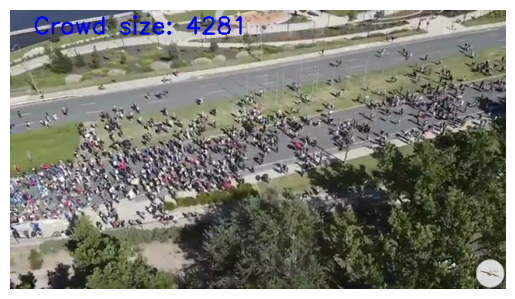

High-density crowd, estimated crowd size: 5750.203704833984
High-density crowd, estimated crowd size: 4470.568084716797
High-density crowd, estimated crowd size: 4342.057418823242
High-density crowd, estimated crowd size: 3837.8433227539062
High-density crowd, estimated crowd size: 5410.359954833984
High-density crowd, estimated crowd size: 4102.317810058594
High-density crowd, estimated crowd size: 4258.234405517578
High-density crowd, estimated crowd size: 4247.5372314453125
High-density crowd, estimated crowd size: 5465.800094604492
High-density crowd, estimated crowd size: 4089.699935913086
High-density crowd, estimated crowd size: 4236.180114746094
High-density crowd, estimated crowd size: 4704.594039916992
High-density crowd, estimated crowd size: 5898.464202880859
High-density crowd, estimated crowd size: 4798.451232910156
High-density crowd, estimated crowd size: 4937.921905517578
High-density crowd, estimated crowd size: 5029.134368896484
High-density crowd, estimated crowd si

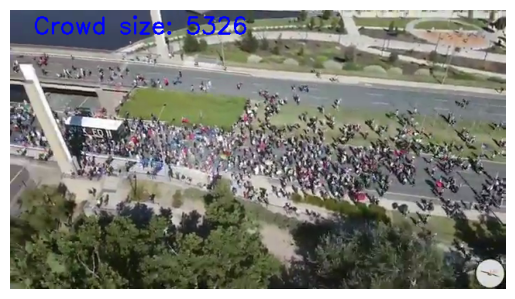

High-density crowd, estimated crowd size: 6050.486755371094
High-density crowd, estimated crowd size: 5423.20671081543
High-density crowd, estimated crowd size: 5576.5899658203125
High-density crowd, estimated crowd size: 5876.628112792969
High-density crowd, estimated crowd size: 6328.206634521484
High-density crowd, estimated crowd size: 5514.548873901367
High-density crowd, estimated crowd size: 5303.90510559082
High-density crowd, estimated crowd size: 5779.664993286133
High-density crowd, estimated crowd size: 6553.044891357422
High-density crowd, estimated crowd size: 5333.305358886719
High-density crowd, estimated crowd size: 5697.019577026367
High-density crowd, estimated crowd size: 5983.502197265625
High-density crowd, estimated crowd size: 10498.641967773438
High-density crowd, estimated crowd size: 8205.94482421875
High-density crowd, estimated crowd size: 7326.607513427734
High-density crowd, estimated crowd size: 7149.181365966797
High-density crowd, estimated crowd size:

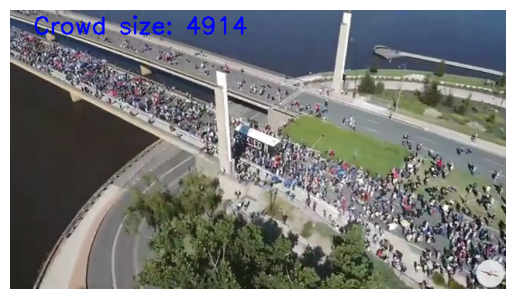

High-density crowd, estimated crowd size: 4732.164764404297
High-density crowd, estimated crowd size: 4557.460021972656
High-density crowd, estimated crowd size: 4646.7926025390625
High-density crowd, estimated crowd size: 4515.034484863281
High-density crowd, estimated crowd size: 5389.500427246094
High-density crowd, estimated crowd size: 4262.635803222656
High-density crowd, estimated crowd size: 4422.0672607421875
High-density crowd, estimated crowd size: 4403.511810302734
High-density crowd, estimated crowd size: 3871.9802856445312
High-density crowd, estimated crowd size: 5221.949768066406
High-density crowd, estimated crowd size: 4337.042236328125
High-density crowd, estimated crowd size: 3888.726806640625
High-density crowd, estimated crowd size: 3655.982208251953
High-density crowd, estimated crowd size: 3744.641876220703
High-density crowd, estimated crowd size: 3636.0137939453125
High-density crowd, estimated crowd size: 4770.683670043945
High-density crowd, estimated crowd 

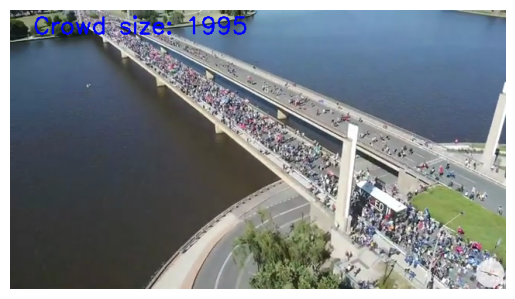

High-density crowd, estimated crowd size: 1735.4785919189453
High-density crowd, estimated crowd size: 1519.333839416504
High-density crowd, estimated crowd size: 1559.4629287719727
High-density crowd, estimated crowd size: 1662.3357772827148
High-density crowd, estimated crowd size: 1395.300579071045
High-density crowd, estimated crowd size: 1524.2969512939453
High-density crowd, estimated crowd size: 1565.6489372253418
High-density crowd, estimated crowd size: 1504.8565864562988
High-density crowd, estimated crowd size: 1453.0139923095703
High-density crowd, estimated crowd size: 1505.859375
High-density crowd, estimated crowd size: 1591.203498840332
High-density crowd, estimated crowd size: 1617.6212310791016
High-density crowd, estimated crowd size: 1651.4265060424805
High-density crowd, estimated crowd size: 1807.4695587158203
High-density crowd, estimated crowd size: 1608.1912994384766
High-density crowd, estimated crowd size: 1526.15966796875
High-density crowd, estimated crowd 

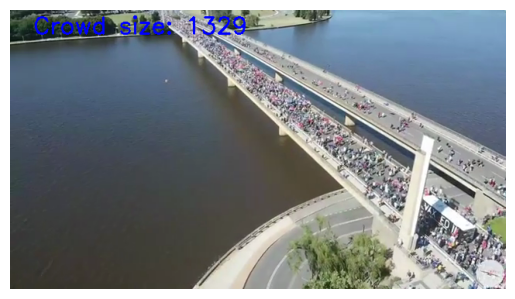


Estimated crowd size (average): 4145.226329076052
Estimated crowd size (max): 10498.641967773438


(4145.226329076052, 10498.641967773438)

In [11]:
video_path = 'Artifacts/bridge_video.mp4'
process_video(video_path, start_time=14, end_time=32)